# Setup


## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import random
random.seed(123)

import time
import os

## Check CUDA version

In [ ]:

use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

## Visualisation functions

In [ ]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Function to show an image tensor
def show(X):
    if X.dim() == 3 and X.size(2) == 3:
        plt.imshow(X.numpy())
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

## Download dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.squeeze()),  # Squeeze the data to remove the redundant channel dimension
                                ])

trainset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                      train=True,
                                      download=True,
                                      transform=transform
                                      )

testset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
)


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw


Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Data preprocessing

## Create train/val/test sets

In [ ]:

from sklearn.model_selection import train_test_split
targets = trainset.targets
train_idx, val_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True, stratify=targets, random_state=123)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

batch_size=128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True
                                         )

## Show data sample

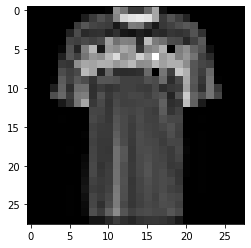

In [ ]:
batch, _ = next(iter(trainloader))
show(batch[0])

# Build network

CNN with:

- ReLU activation
- Softmax activation at the end
- Dense Layer at the end
- Half padding to maintain spatial footprint of the image (1 for kernel size 3, 2 for kernel size 5)
- Cross entropy loss
- Net architechture: 2 convolutional layers, 2 dense layers

In [ ]:
class Net(nn.Module):

    def __init__(self, kernel_size, pool_function, nfilters_conv1, nfilters_conv2):

        super(Net, self).__init__()
        self.nfilters_conv2 = nfilters_conv2

        # CL1:   1 x 28 x 28 (grayscale) -->    nfilters_conv1 x 28 x 28 
        self.conv1 = nn.Conv2d(1, nfilters_conv1,  kernel_size=kernel_size,  padding=kernel_size//2)

        # MP1: nfilters_conv1 x 28 x 28  -->    nfilters_conv1 x 14 x 14
        self.pool1  = pool_function(2,2)
        
        # CL2:   nfilters_conv1 x 14 x 14  -->    nfilters_conv2 x 14 x 14
        self.conv2 = nn.Conv2d(nfilters_conv1,  nfilters_conv2,  kernel_size=kernel_size,  padding=kernel_size//2)
        
        # MP2:  nfilters_conv2 x 14 x 14 -->    nfilters_conv2 x 7 x 7
        self.pool2 = pool_function(2,2)
        
        # LL1:   nfilters_conv2 x 7 x 7 -->  100 
        self.linear1 = nn.Linear((nfilters_conv2*7*7), 100)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(100,10)


    def forward(self, x):
        x = x.unsqueeze(1)

        # CL1:   
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 
        x = self.pool1(x)
        
        # CL2:   
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 
        x = self.pool2(x)

        # LL1:   
        x = x.view(-1, self.nfilters_conv2*7*7)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:  
        x = self.linear2(x)
    
        return x

# Hyperparameter tuning
- Number of filters
- Kernel size: 3 or 5 
- Stride: 1 or 2?
- Pooling function: MaxPool, AvgPool
- Optimizer: ADAM, RMSProp, SGD, AdaDelta, AdaGrad

## Import libraries

In [ ]:
!pip install ray

In [ ]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

## Define training function

In [ ]:
def train(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["kernel_size"], config["pool_function"], config["nfilters_conv1"], config["nfilters_conv2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = config["optimizer"](net.parameters(), lr=0.01)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    for epoch in range(50):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        #for i, data in enumerate(trainloader, 0):
        for i, (x_batch, y_batch) in enumerate(trainloader,0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            # inputs, labels = inputs.to(device), labels.to(device)
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # outputs = net(inputs)
            y_pred = net(x_batch)
            #loss = criterion(outputs, labels)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (x_batch, y_batch) in enumerate(valloader,0):
            with torch.no_grad():
                # inputs, labels = data
                # inputs, labels = inputs.to(device), labels.to(device)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = net(x_batch)
                _, predicted = torch.max(y_pred.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

                # outputs = net(inputs)
                # _, predicted = torch.max(outputs.data, 1)
                # total += labels.size(0)
                # correct += (predicted == labels).sum().item()

                loss = criterion(y_pred, y_batch)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [ ]:
!pip install tensorboardX

## Perform random search

In [ ]:
from functools import partial

def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    #data_dir = os.path.abspath("./data_faces")
    #load_data(data_dir)
    config = {
        "kernel_size": tune.choice([3,5]),
        "pool_function": tune.choice([nn.MaxPool2d, nn.AvgPool2d]),
        "nfilters_conv1": tune.choice([2,4,8,16,32,64,128,256]),
        "nfilters_conv2": tune.choice([2,4,8,16,32,64,128,256]),
        "optimizer": tune.choice([torch.optim.SGD, torch.optim.Adam, torch.optim.Adadelta, torch.optim.RMSprop])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=3,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["kernel_size", "stride", "pool_function", "nfilters_conv1", "nfilters_conv2", "optimizers"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train, data_dir=trainset),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["kernel_size"], 
                               best_trial.config["pool_function"], best_trial.config["nfilters_conv1"], 
                               best_trial.config["nfilters_conv2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=100, max_num_epochs=50, gpus_per_trial=1)

Output hidden; open in https://colab.research.google.com to view.